# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import sqlalchemy
from scipy import interpolate
from psycopg2.extras import NumericRange
password = open('../password.txt', 'r').read()

# Get data from database

In [2]:
engine = sqlalchemy.create_engine("postgresql://postgres:%s@localhost/MAYHEM-Example" % password)
con = engine.connect()

In [3]:
model_output = pd.read_sql('modeloutput', con)
model_output = model_output.sort_values(by = 'measurementid', ignore_index = True)
model_output = model_output[model_output['model_name'] == 'Undatable']
measurement = pd.read_sql('measurement', con)
organics = pd.read_sql('organic', con)
elements = pd.read_sql('element', con)

In [4]:
con.close()

# Prep data

In [5]:
toc = organics[['measurementid','toc']].copy()

In [6]:
bromine = elements[elements['element_name'].str.contains('Br_Area')].copy()

In [7]:
toc.dropna(inplace = True)

In [8]:
for index, row in toc.iterrows():
    if type(row['toc']) == NumericRange and row['toc'].upper == row['toc'].lower:
        toc.at[index, 'toc'] = row['toc'].upper
    else:
        toc.drop(index, inplace=True)

In [9]:
for index, row in bromine.iterrows():
    if type(row['element_value']) == NumericRange and row['element_value'].upper == row['element_value'].lower:
        bromine.at[index, 'element_value'] = row['element_value'].upper
    else:
        bromine.drop(index, inplace=True)

In [10]:
toc_depth = pd.merge(toc,
                     measurement,
                     how = 'left',
                     on = ['measurementid'])

In [11]:
bromine_depth = pd.merge(bromine,
                     measurement,
                     how = 'left',
                     on = ['measurementid'])

In [12]:
shared_coreid = bromine_depth.coreid.unique()

In [14]:
toc_depth = toc_depth[toc_depth['coreid'].isin(shared_coreid)]

In [15]:
br_toc_comparison = pd.merge(bromine_depth, toc_depth, how = 'outer', on = ['measurementid', 'coreid', 'compositedepth'])

# Plotting output from database

In [16]:
def hex_to_rgb(hex_value):
  h = hex_value.lstrip('#')
  return tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

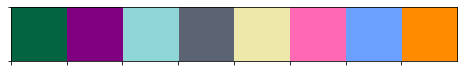

In [17]:
hex_colors = ['#026440', #canary           ## PG1972
              '#800080', #palegreen        ## PG1975
              '#90d6d6', #aqua island      ## PG1982
              '#5c6473', #shuttle grey     ## PG2023
              '#eee8aa', #palegoldenrod    ## PG2133
              '#ff69b4', #hotpink          ## PG2135
              '#6ba0ff', #cornflower       ## PG2208
              '#ff8c00'  #darkorange       ## PG2367
             ]


Br_palette_colors = list(map(hex_to_rgb, hex_colors))
sns.palplot(Br_palette_colors)

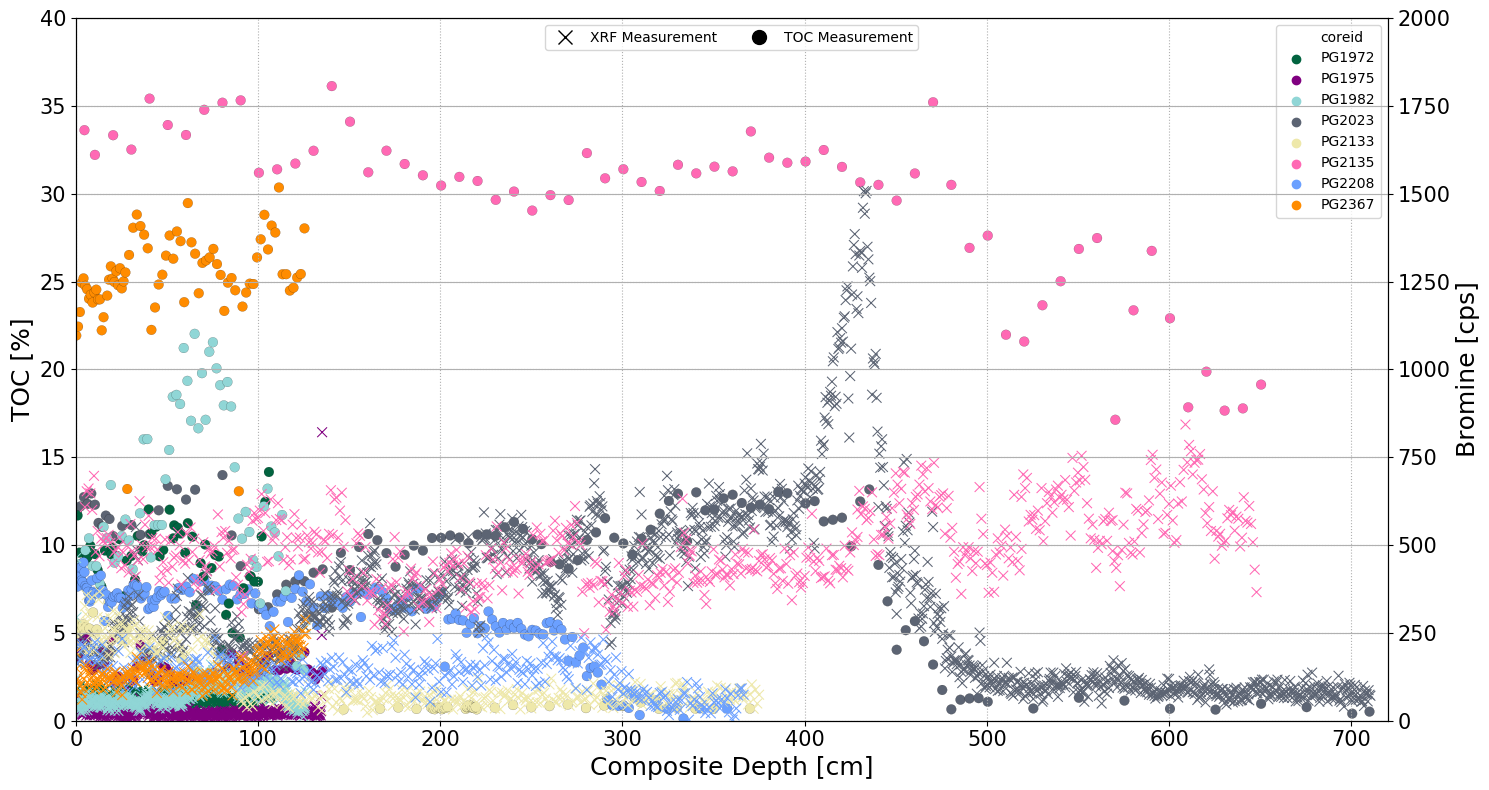

In [18]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax1 = plt.subplots(figsize=(15,8), sharex = True)

sns.scatterplot(x = 'compositedepth', y = 'toc', hue = 'coreid', data = br_toc_comparison, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1)
ax1.set_xlabel('Composite Depth [cm]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 720)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'compositedepth', y = 'element_value', hue = 'coreid', palette = Br_palette_colors, data = br_toc_comparison, marker = 'x', s = 50, legend = 'brief')
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
#plt.savefig('Figures/Figure6a.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Transform data from depth-dependent to age-dependent

In [20]:
model = pd.merge(model_output[['measurementid', 'modeloutput_median']],
                   measurement,
                   how = 'outer',
                   on = ['measurementid'])
model = model[model['coreid'].isin(shared_coreid)]
model.drop_duplicates(['coreid','compositedepth'], inplace = True)

In [21]:
br_toc_time = pd.merge(br_toc_comparison,
                       model,
                       how = 'outer',
                       on = ['coreid', 'compositedepth'])

In [22]:
br_toc_time_comparison = br_toc_time.sort_values(by = ['coreid', 'compositedepth'], ignore_index = True).drop(columns = ['measurementid_y','measurementid_x'])
br_toc_time_comparison['compositedepth'] = br_toc_time_comparison['compositedepth'].astype(np.float32)

In [23]:
br_toc_time_comparison = br_toc_time_comparison.set_index('coreid')
br_toc_time_comparison.drop('element_name', axis = 1, inplace = True)

In [24]:
age_interpol = pd.DataFrame(columns = ['coreid', 'toc', 'element_value'])
for i in shared_coreid:
    df2 = br_toc_time_comparison.loc[i].copy()
    df2.reset_index(inplace = True)
    df2.set_index('compositedepth', inplace = True)
    x = df2['modeloutput_median'].dropna().index.values
    xnew = df2.index.values
    y = df2['modeloutput_median'].dropna().values
    y = y.reshape(-1, 1)  ### remove when linear interpolating
    f = interpolate.BPoly.from_derivatives(x, y)
    #f = interpolate.interp1d(x, y, fill_value = 'extrapolate')
    df2['modeloutput_median'] = f(xnew)
    df2.set_index('modeloutput_median', inplace = True)
    age_interpol = pd.concat([age_interpol, df2])

age_interpol.reset_index(inplace = True)
age_interpol.rename(columns = {'index' : 'modeloutput_median'}, inplace = True)    

# Plotting age-transformed data

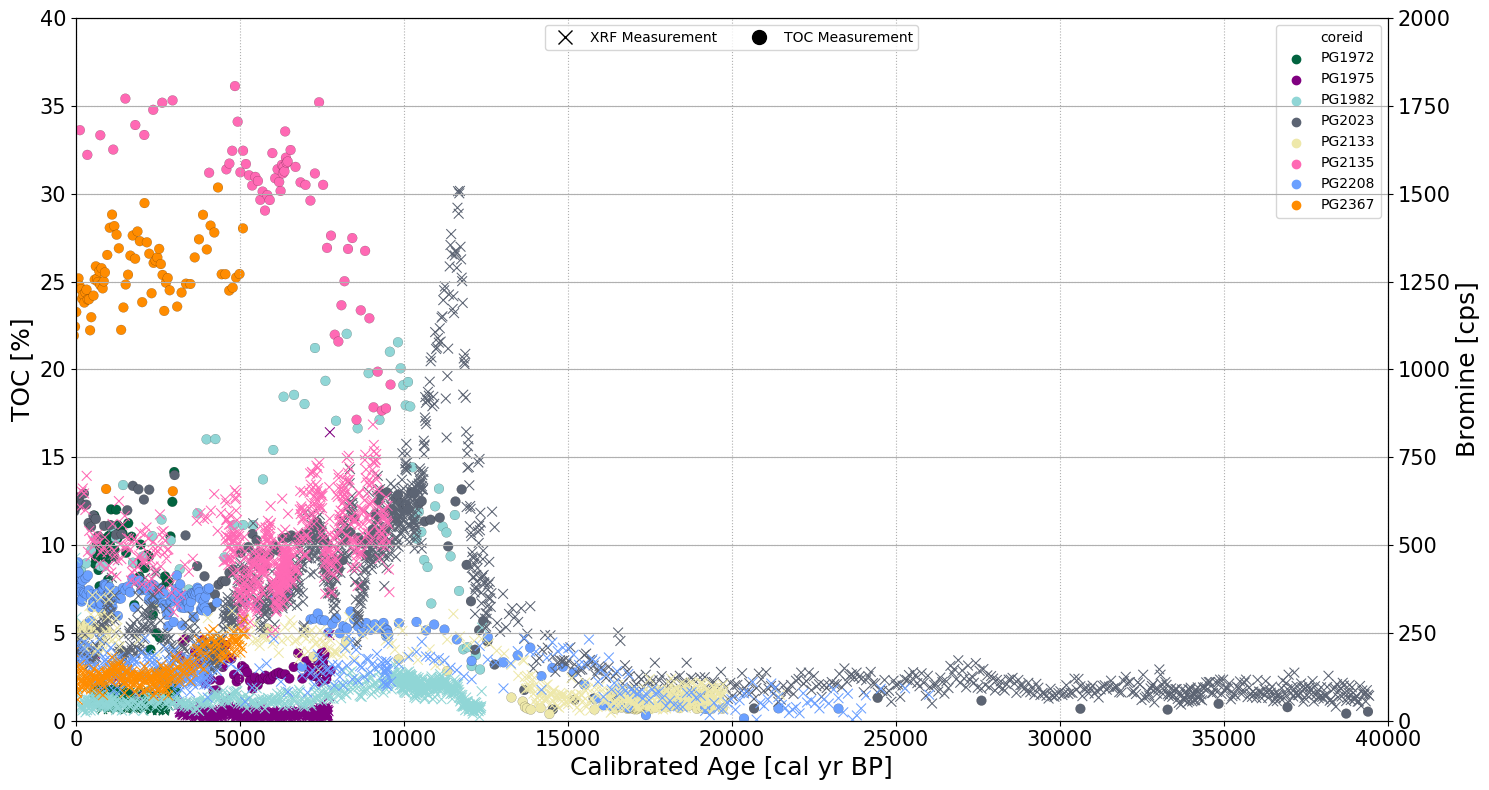

In [25]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax1 = plt.subplots(figsize=(15,8), sharex = True)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = age_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1)
ax1.set_xlabel('Calibrated Age [cal yr BP]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 40000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = age_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief')
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
#plt.savefig('Figures/Figure6b.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

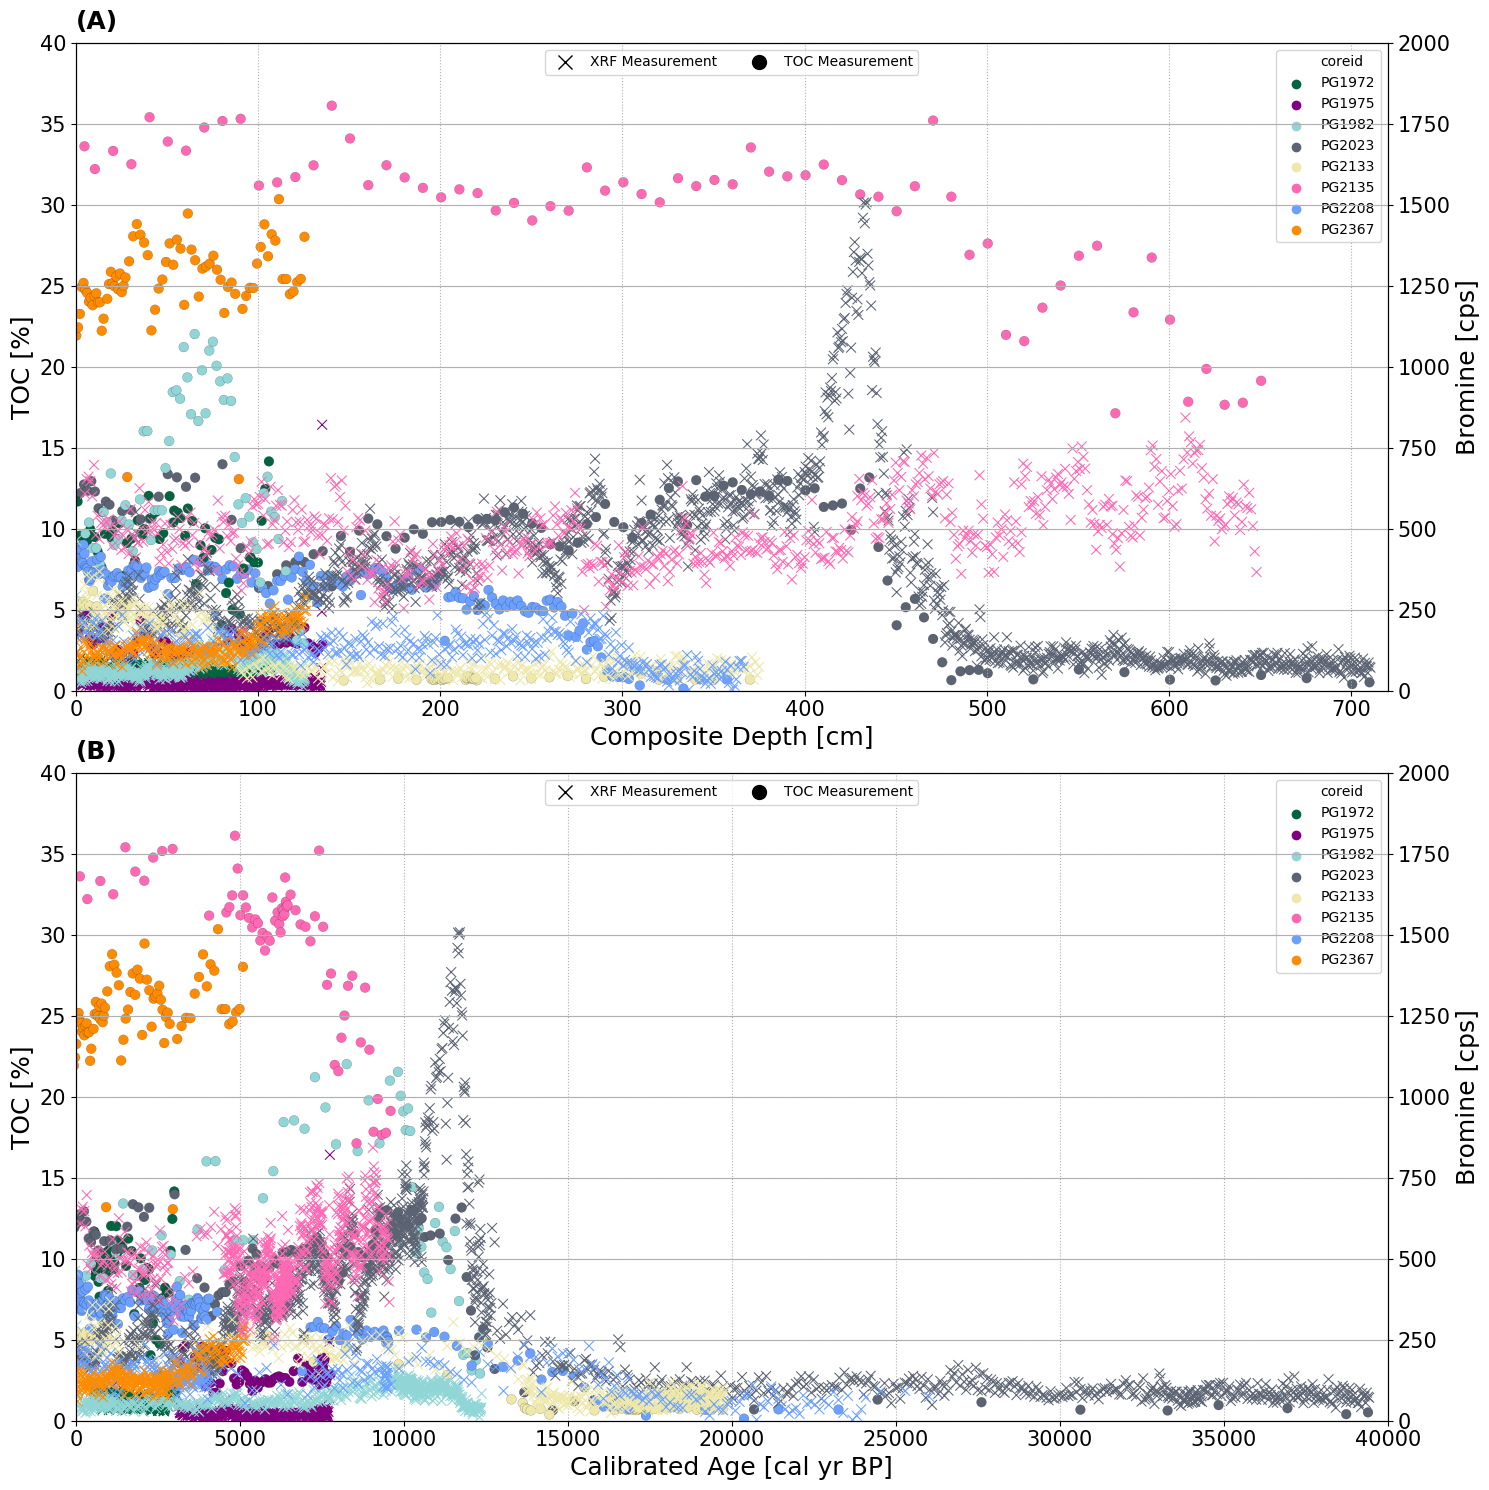

In [27]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)

sns.scatterplot(x = 'compositedepth', y = 'toc', hue = 'coreid', data = br_toc_comparison, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1, ax = ax1)
ax1.set_xlabel('Composite Depth [cm]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 720)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'compositedepth', y = 'element_value', hue = 'coreid', palette = Br_palette_colors, data = br_toc_comparison, marker = 'x', s = 50, legend = 'brief', ax = ax2)
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
ax1.set_title('(A)', loc = 'left', pad = (10), fontsize = BIGGER_SIZE, fontweight = 'bold')

ax3 = fig.add_subplot(212)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = age_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1, ax = ax3)
ax3.set_xlabel('Calibrated Age [cal yr BP]')
ax3.set_ylabel('TOC [%]')
ax3.set_ylim(0, 40)
ax3.set_xlim(0, 40000)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = age_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief', ax = ax4)
ax4.set_ylabel('Bromine [cps]') 
ax4.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.grid(linestyle = ':')
ax4.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
ax3.set_title('(B)', loc = 'left', pad = (10), fontsize = BIGGER_SIZE, fontweight = 'bold')
#plt.savefig('Figures/Figure6.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Using TOC as base proxy for matching process

In [32]:
element_interpol = pd.DataFrame(columns = ['coreid', 'toc', 'element_value'])
element_prep_interpol = age_interpol.copy()
element_prep_interpol.set_index('coreid', inplace = True)
for i in shared_coreid:
    df3 = element_prep_interpol.loc[i].copy()
    df3.reset_index(inplace = True)
    df3.set_index('modeloutput_median', inplace = True)
    for el in ['element_value']:    
        x = df3[el].dropna().index.values
        xnew = df3.index.values
        y = df3[el].dropna().values.astype(float)
        y = y.reshape(-1, 1) ### remove when linear interpolating
        f = interpolate.BPoly.from_derivatives(x, y)
        #f = interpolate.interp1d(x, y, fill_value = 'extrapolate')
        ynew = f(xnew)
        df3.loc[:, el] = ynew  
        df3['coreid'] = i
        df3.index = df3.index
    element_interpol = pd.concat([element_interpol, df3])

element_interpol.reset_index(inplace = True)
element_interpol.rename(columns = {'index' : 'modeloutput_median'}, inplace = True) 
element_interpol.dropna(inplace = True)

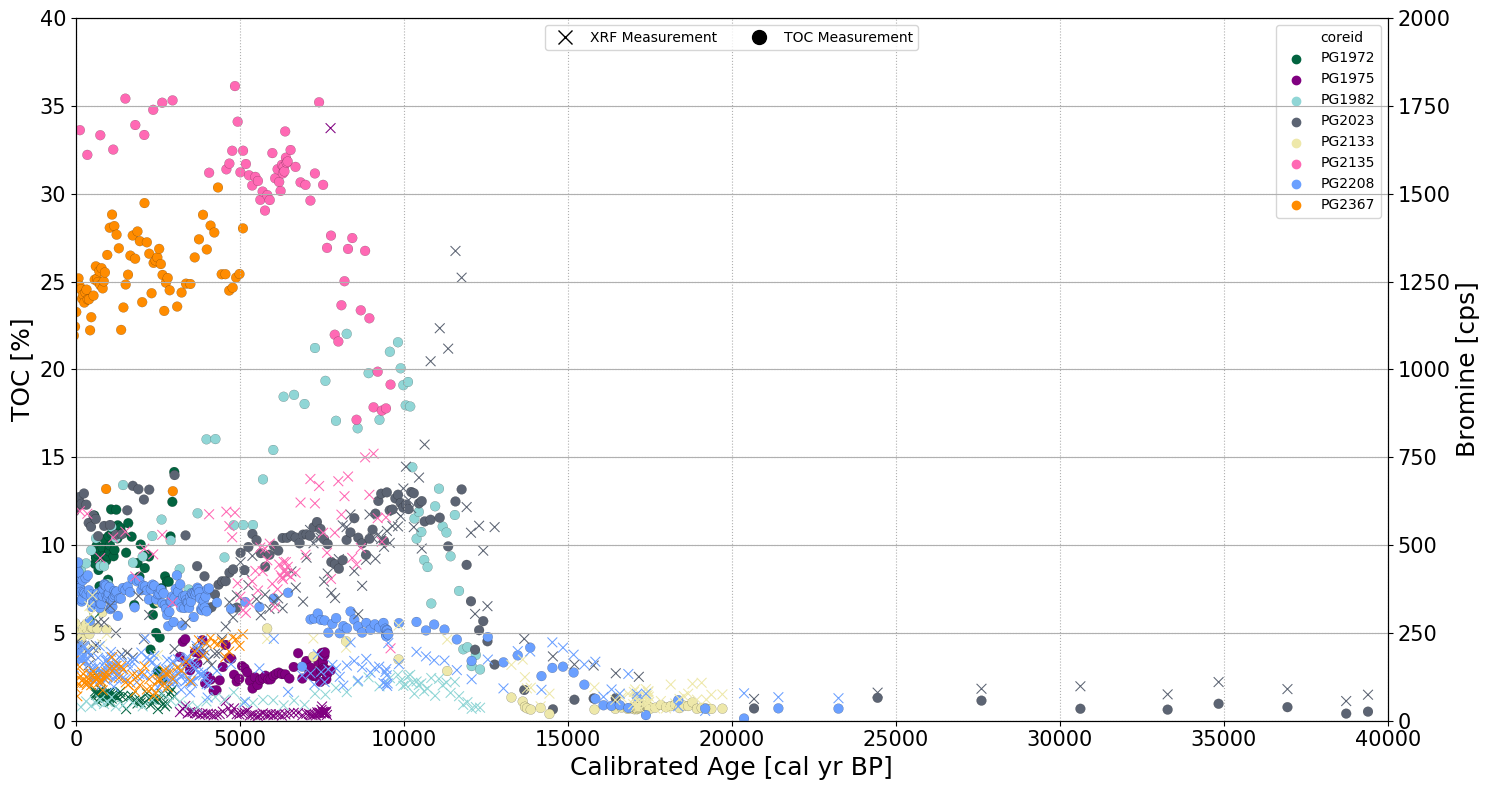

In [33]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax1 = plt.subplots(figsize=(15,8), sharex = True)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = element_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1)
ax1.set_xlabel('Calibrated Age [cal yr BP]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 40000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = element_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief')
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
#plt.savefig('Figures/Figure7a.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Using bromine as base proxy for matching process

In [34]:
toc_interpol = pd.DataFrame(columns = ['coreid', 'toc', 'element_value'])
toc_prep_interpol = age_interpol.copy()
toc_prep_interpol.set_index('coreid', inplace = True)
for i in shared_coreid:
    df3 = toc_prep_interpol.loc[i].copy()
    df3.reset_index(inplace = True)
    df3.set_index('modeloutput_median', inplace = True)
    for el in ['toc', 'element_value']:    
        x = df3[el].dropna().index.values
        xnew = df3.index.values
        y = df3[el].dropna().values.astype(float)
        y = y.reshape(-1, 1) ### remove when linear interpolating
        f = interpolate.BPoly.from_derivatives(x, y)
        #f = interpolate.interp1d(x, y, fill_value = 'extrapolate')
        ynew = f(xnew)
        df3.loc[:, el] = ynew  
        df3['coreid'] = i
        df3.index = df3.index
    toc_interpol = pd.concat([toc_interpol, df3])

toc_interpol.reset_index(inplace = True)
toc_interpol.rename(columns = {'index' : 'modeloutput_median'}, inplace = True)    

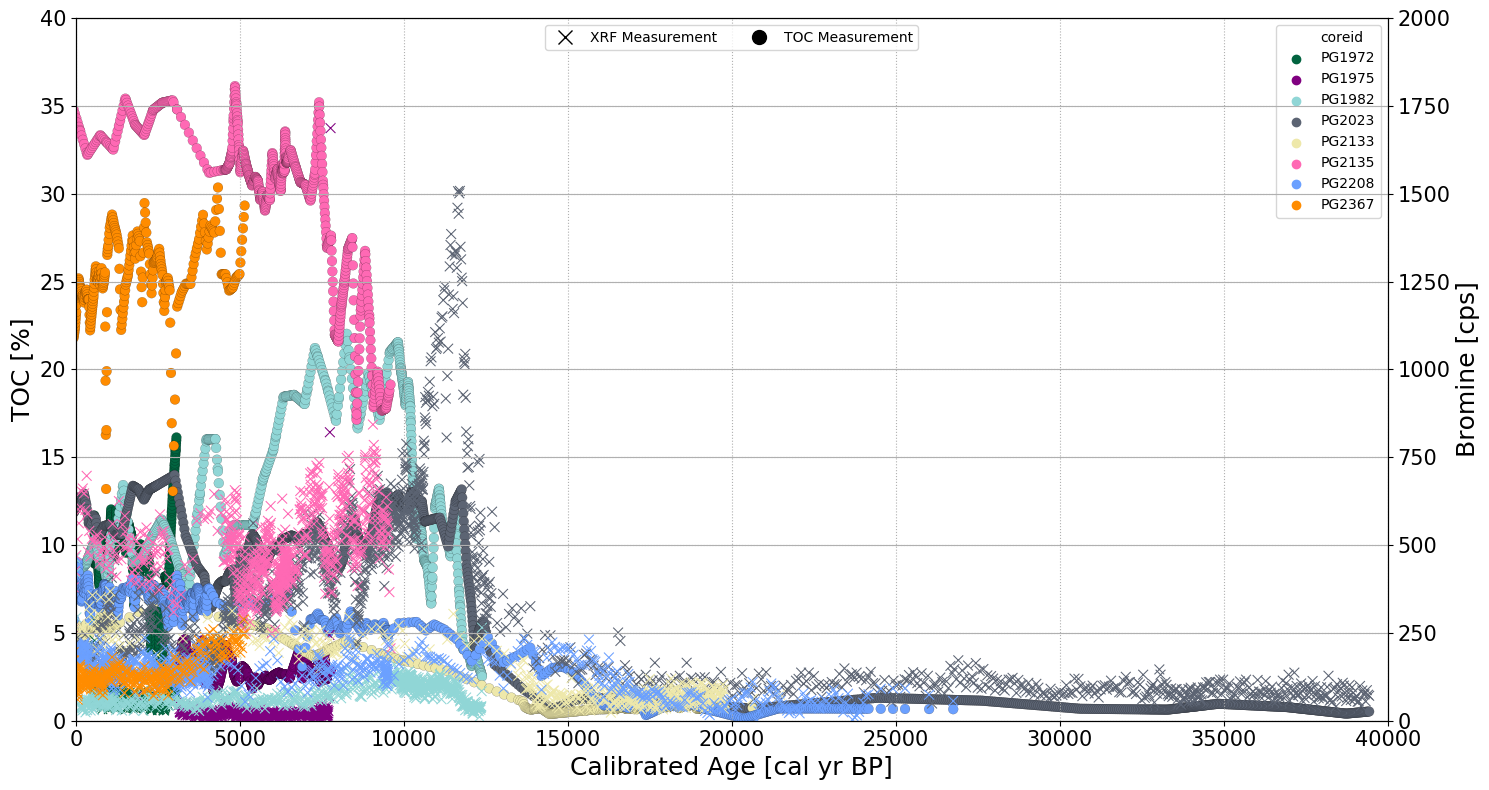

In [35]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax1 = plt.subplots(figsize=(15,8), sharex = True)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = toc_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1)
ax1.set_xlabel('Calibrated Age [cal yr BP]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 40000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = toc_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief')
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
#plt.savefig('Figures/Figure7b.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

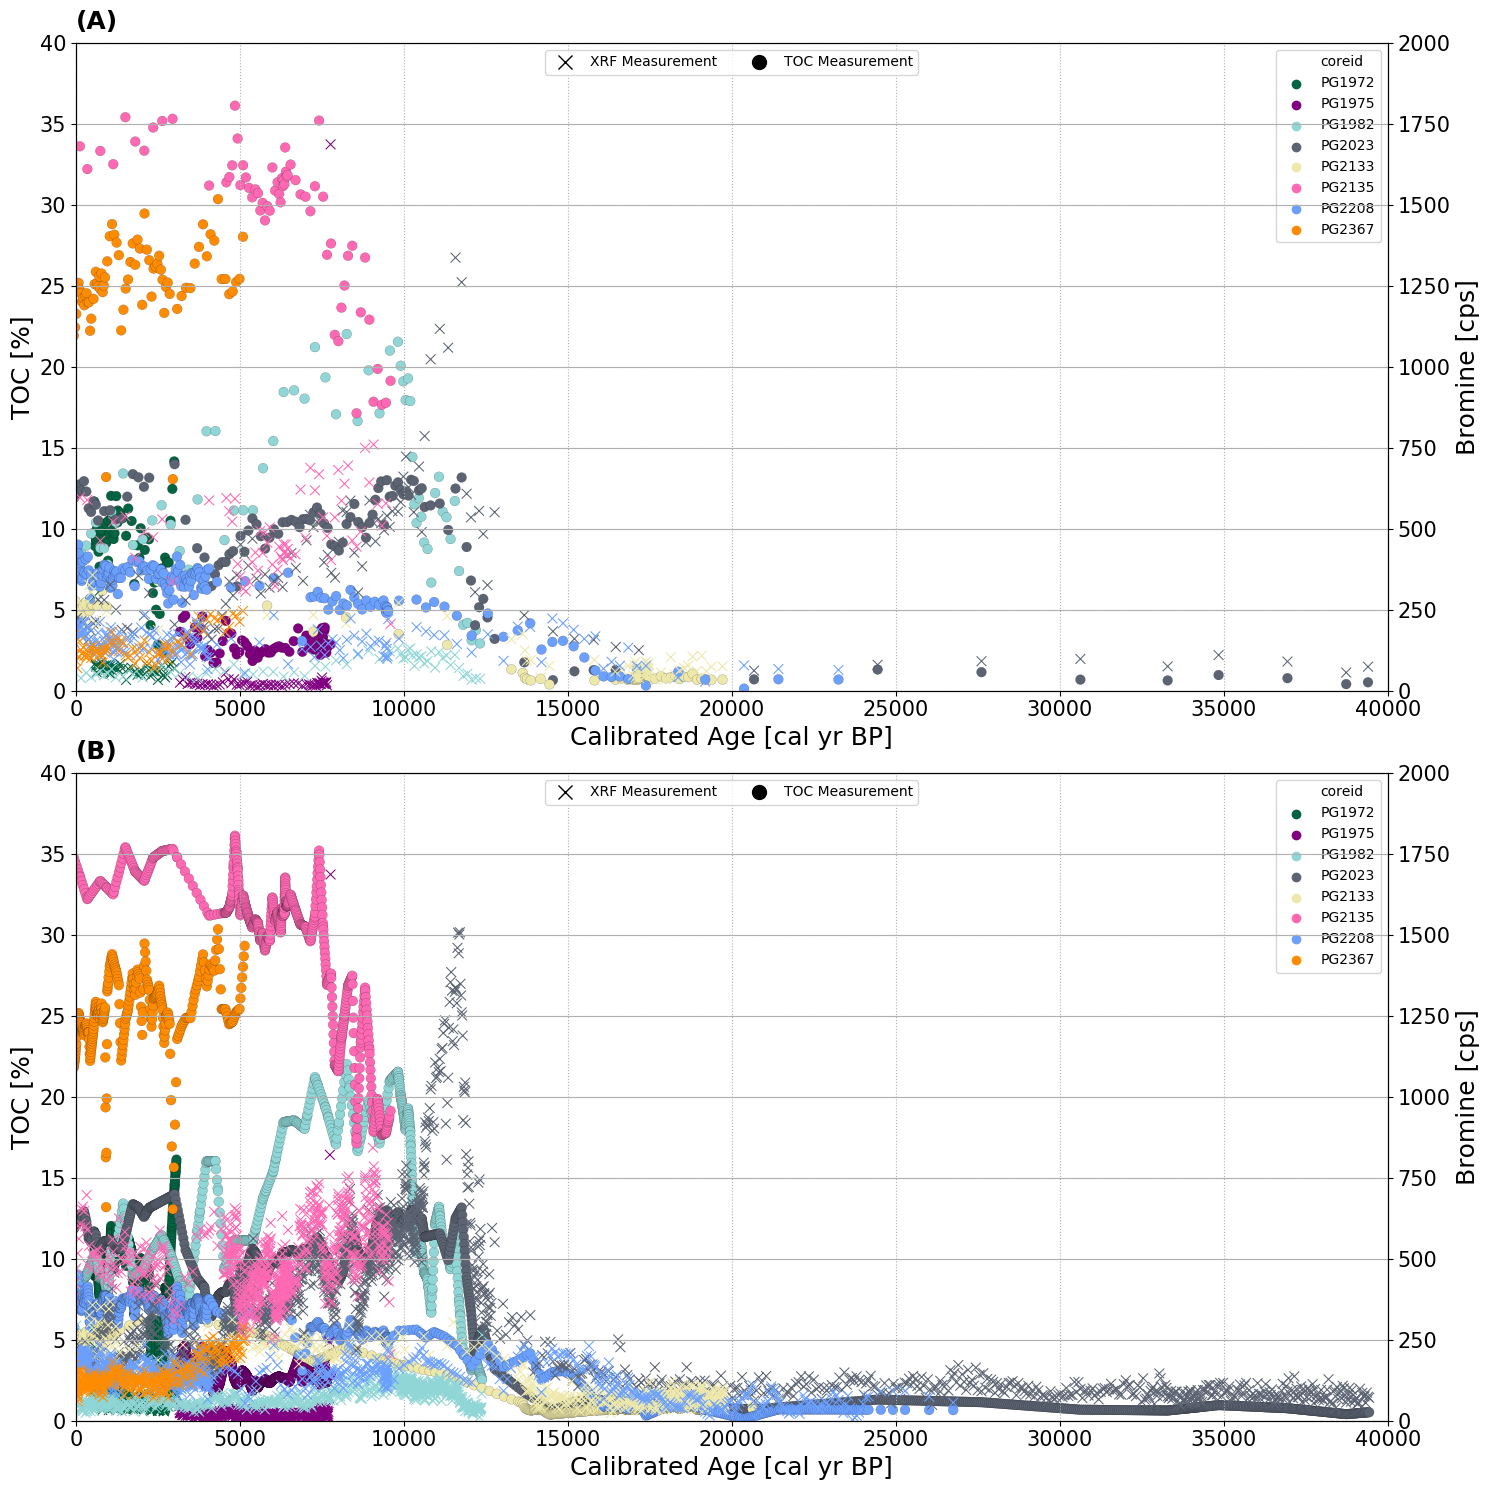

In [37]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(211)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = element_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1, ax = ax1)
ax1.set_xlabel('Calibrated Age [cal yr BP]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 40000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = element_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief', ax = ax2)
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle = ':')
ax2.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
ax1.set_title('(A)', loc = 'left', pad = (10), fontsize = BIGGER_SIZE, fontweight = 'bold')

ax3 = fig.add_subplot(212)

sns.scatterplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = toc_interpol, palette = Br_palette_colors, marker = '.', s = 200, legend = 'brief', edgecolor = 'black', linewidth = 0.1, ax = ax3)
ax3.set_xlabel('Calibrated Age [cal yr BP]')
ax3.set_ylabel('TOC [%]')
ax3.set_ylim(0, 40)
ax3.set_xlim(0, 40000)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

sns.scatterplot(x = 'modeloutput_median', y = 'element_value', hue = 'coreid', data = toc_interpol, palette = Br_palette_colors, marker = 'x', s = 50, legend = 'brief', ax = ax4)
ax4.set_ylabel('Bromine [cps]') 
ax4.set_ylim(0, 2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.grid(linestyle = ':')
ax4.grid()
xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
ax3.set_title('(B)', loc = 'left', pad = (10), fontsize = BIGGER_SIZE, fontweight = 'bold')

#plt.savefig('Figures/Figure7.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Equidistant preparation

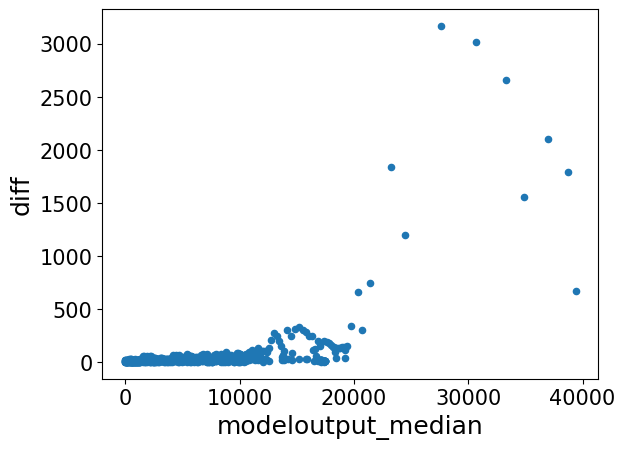

In [38]:
equidistant = element_interpol.sort_values(by = ['modeloutput_median']).copy()
equidistant['diff'] = equidistant.sort_values(by = ['modeloutput_median']).modeloutput_median.diff()
equidistant.plot(x = 'modeloutput_median', y = 'diff', kind = 'scatter')
plt.show()

In [39]:
max_resolution = []
for core in equidistant.coreid.unique():
    mean_calculate = equidistant[equidistant['coreid'] == core]
    max_resolution.append(mean_calculate['diff'].max())
optimal_bin = round(sum(max_resolution) / len(max_resolution), -2)
print (f'The optimal bin size is: {optimal_bin}')

The optimal bin size is: 700.0


In [40]:
equidistant = equidistant.copy()
equidistant[['toc', 'element_value']] = equidistant[['toc','element_value']].astype(float)
equidistant.drop('diff', axis = 1, inplace = True)

In [41]:
error_equidis = pd.DataFrame()
year_bin = optimal_bin
max_range = (round(equidistant.modeloutput_median.max()/year_bin)+1)
for core in equidistant.coreid.unique():
    for i in range(0,max_range):
        core_frame = equidistant[equidistant['coreid'] == core]
        core_max_age = equidistant[equidistant['coreid'] == core].modeloutput_median.max()
        y = i*year_bin
        
        selection = core_frame[(core_frame['modeloutput_median'] > (y - year_bin/2)) & (core_frame['modeloutput_median'] <= (y + year_bin/2))]
        selection = selection.copy()
        if len(selection[selection['modeloutput_median'] == y]) > 0:
            yerr_max_toc = np.abs(selection['toc'].max() - selection[selection['modeloutput_median'] == y]['toc'].values) 
            yerr_min_toc = np.abs(selection[selection['modeloutput_median'] == y]['toc'].values - selection['toc'].min())
            yerr_max_element = np.abs(selection['element_value'].max() - selection[selection['modeloutput_median'] == y]['element_value'].values) 
            yerr_min_element = np.abs(selection[selection['modeloutput_median'] == y]['element_value'].values - selection['element_value'].min())
            error_equidis = error_equidis.append(pd.DataFrame(data = [[y, core, (selection[selection['modeloutput_median'] == y]['toc'].values), 
                                                                                 (selection[selection['modeloutput_median'] == y]['element_value'].values),
                                                                                 yerr_min_toc, yerr_max_toc, yerr_min_element, yerr_max_element, (year_bin/2)]], 
                                                                        columns = ['modeloutput_median', 'coreid', 'toc', 'element_value', 
                                                                                   'ymin_toc', 'ymax_toc', 'ymin_element', 'ymax_element', 'xerr']))
          
        else:
            if len(selection) > 1:
                selection = selection.append(pd.DataFrame(np.array([[y, core, None, None]]), 
                                                  columns = ['modeloutput_median','coreid','toc','element_value'])).sort_values(by = ['modeloutput_median'])
                selection.interpolate(inplace = True)
                yerr_max_toc = np.abs(selection['toc'].max() - selection[selection['modeloutput_median'] == y]['toc'].values) 
                yerr_min_toc = np.abs(selection[selection['modeloutput_median'] == y]['toc'].values - selection['toc'].min())
                yerr_max_element = np.abs(selection['element_value'].max() - selection[selection['modeloutput_median'] == y]['element_value'].values) 
                yerr_min_element = np.abs(selection[selection['modeloutput_median'] == y]['element_value'].values - selection['element_value'].min())
                error_equidis = error_equidis.append(pd.DataFrame(data = [[y, core, (selection[selection['modeloutput_median'] == y]['toc'].values), 
                                                                                 (selection[selection['modeloutput_median'] == y]['element_value'].values),
                                                                                 yerr_min_toc, yerr_max_toc, yerr_min_element, yerr_max_element, (year_bin/2)]], 
                                                                        columns = ['modeloutput_median', 'coreid', 'toc', 'element_value', 
                                                                                   'ymin_toc', 'ymax_toc', 'ymin_element', 'ymax_element', 'xerr']))
            elif len(selection) == 1:
                if y <= core_max_age:
                    for expand in range(0, max_range):
                        if len(selection) < 2: 
                            selection = core_frame[(core_frame['modeloutput_median'] > (y - expand*(year_bin/2))) & (core_frame['modeloutput_median'] <= (y + expand*(year_bin/2)))]
                            selection = selection.copy()
                        else:
                            break
                    if len(selection) >= 2:
                        selection = selection.append(pd.DataFrame(np.array([[y, core, None, None]]), 
                                                          columns = ['modeloutput_median','coreid','toc','element_value'])).sort_values(by = ['modeloutput_median'])
                        selection.interpolate(inplace = True)
                        yerr_max_toc = np.abs(selection['toc'].max() - selection[selection['modeloutput_median'] == y]['toc'].values) 
                        yerr_min_toc = np.abs(selection[selection['modeloutput_median'] == y]['toc'].values - selection['toc'].min())
                        yerr_max_element = np.abs(selection['element_value'].max() - selection[selection['modeloutput_median'] == y]['element_value'].values) 
                        yerr_min_element = np.abs(selection[selection['modeloutput_median'] == y]['element_value'].values - selection['element_value'].min())
                        error_equidis = error_equidis.append(pd.DataFrame(data = [[y, core, (selection[selection['modeloutput_median'] == y]['toc'].values), 
                                                                                     (selection[selection['modeloutput_median'] == y]['element_value'].values),
                                                                                     yerr_min_toc, yerr_max_toc, yerr_min_element, yerr_max_element, (year_bin/2)]], 
                                                                                    columns = ['modeloutput_median', 'coreid', 'toc', 'element_value', 
                                                                                       'ymin_toc', 'ymax_toc', 'ymin_element', 'ymax_element', 'xerr']))
                    else:
                        pass
                else:
                    pass
            else:
                pass
            
error_equidis.reset_index(drop = True, inplace = True)
for e in ['toc', 'element_value', 'ymin_toc', 'ymax_toc', 'ymin_element', 'ymax_element']:
    error_equidis = error_equidis.explode(e)

# Plotting equidistant data

In [42]:
import matplotlib.colors as colors
hex_dict = {'PG1972' : '#026440', #canary 
           'PG1975': '#800080', #palegreen
           'PG1982': '#90d6d6', #aqua island
           'PG2023': '#5c6473', #shuttle grey
           'PG2133': '#eee8aa', #palegoldenrod
           'PG2135': '#ff69b4', #hotpink
           'PG2208': '#6ba0ff', #cornflower
           'PG2367': '#ff8c00'  #darkorange
           }

rgba_dict = {}
for core_name, color in hex_dict.items():
    rgba_color = colors.to_rgba(color)
    rgba_dict[core_name] = rgba_color

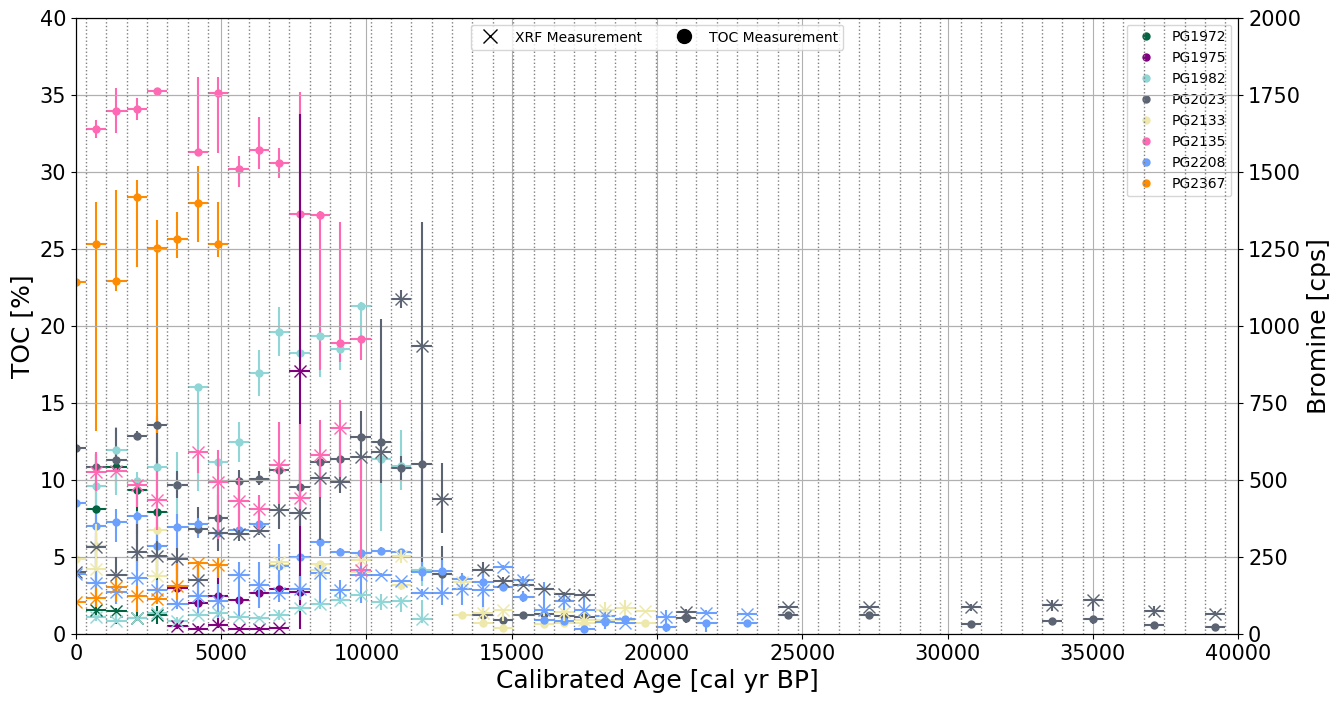

In [69]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax1 = plt.subplots(figsize = (15,8), sharex = True)
for core_name, core_color in rgba_dict.items():
    slice_plot = error_equidis[error_equidis['coreid'] == core_name]
    toc = plt.errorbar(x = 'modeloutput_median', y = 'toc', xerr = slice_plot['xerr'], yerr = (slice_plot['ymin_toc'], slice_plot['ymax_toc']), data = slice_plot, marker = 'o', markersize = 5, color = core_color, linestyle = 'None')
ax1.set_xlabel('Calibrated Age [cal yr BP]')
ax1.set_ylabel('TOC [%]')
ax1.set_ylim(0, 40)  
ax1.set_xlim(0, 40000)

ax2 = ax1.twinx()
for core_name, core_color in rgba_dict.items():
    slice_plot = error_equidis[error_equidis['coreid'] == core_name]
    plt.errorbar(x = 'modeloutput_median', y = 'element_value', xerr = slice_plot['xerr'], yerr = (slice_plot['ymin_element'], slice_plot['ymax_element']), data = slice_plot, marker = 'x', markersize = 8, color = core_color, linestyle = 'None')
ax2.set_ylabel('Bromine [cps]') 
ax2.set_ylim(0, 2000)

xrf_label = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=10, label='XRF Measurement')
toc_label = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='TOC Measurement')
leg1 = plt.legend(handles = [xrf_label, toc_label], loc  = 'upper center', ncol = 3)
handles, labels = ax1.get_legend_handles_labels()
handles = [h[0] for h in handles]
leg2 = ax1.legend(handles, rgba_dict, loc='upper right',numpoints=1)
ax1.grid()
ax2.grid()
for xc in range(int(year_bin/2), 40000, int(year_bin)):
    plt.axvline(x = xc, color = 'grey', linestyle = 'dotted', linewidth = 1)
#plt.savefig('Figures/Figure8_700.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()